In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import netCDF4
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import h5py as h5
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wrf import getvar, interplevel, to_np, get_basemap, latlon_coords,latlon_coords, smooth2d,get_cartopy, cartopy_xlim, cartopy_ylim,ll_to_xy
import pandas as pd
import csv

In [3]:
def wrf_pres(P,PB):
    return (P+PB) #in Pa

def wrf_height(PH,PHB):
    return (PH+PHB)/9.81

def wrf_theta(PTEMP):
    return (PTEMP+300.)

def wrf_temp(THETA,PRES):
    return (THETA)*(PRES/1000.)**(.2854) # in hPa
def es(T):
    return (610.7*np.exp(((2500800+(4218-1870.4)*273.16)*(1/273.16-1/T)-(4218-1870.4)*np.log(T/273.16))/461.51))

In [4]:
file = Dataset('20170108c1.nc')
time = file['TIME'][:]
#CURRENTLY LWC
flight_lwc = file['cdplwc_NRB'][:]
#flight_lwc = file['cdpconc_NRB'][:]
flight_NRB = file['cdpconc_NRB'][:]
plane_altitude = file['GALT'][:]
plane_pressure = file['ps_weston'][:]

In [87]:
#Leg 1 24512 25609
#Leg 2 25816 31613
#Leg 3 32000 32735
#Leg 4 33040 35057
#Leg 5 35329 40507
#Leg 6 40749 42909
#Leg 7 43153 44300
#Leg 8 44532 50652
#Leg 9 50928 52104
#Leg 10 52310 53130

In [88]:
leg_list =[]
#start of leg 1
l1_start = int(np.where(time == 24512)[0])
leg_list.append(l1_start)
#end of leg 1
l1_end = int(np.where(time == 25609)[0])
leg_list.append(l1_end)
#start of leg 2
l2_start = int(np.where(time == 25816)[0])
leg_list.append(l2_start)
#end of leg 2
l2_end = int(np.where(time == 31613)[0])
leg_list.append(l2_end)
#start leg 3
l3_start = int(np.where(time == 32000)[0])
leg_list.append(l3_start)
#end leg 3
l3_end = int(np.where(time == 32735)[0])
leg_list.append(l3_end)
#start leg 4
l4_start = int(np.where(time == 33040)[0])
leg_list.append(l4_start)
#end leg 4
l4_end = int(np.where(time == 35057)[0])
leg_list.append(l4_end)
#start leg 5
l5_start = int(np.where(time == 35329)[0])
leg_list.append(l5_start)
#end leg 5
l5_end = int(np.where(time == 40507)[0])
leg_list.append(l5_end)
#start leg 6
l6_start = int(np.where(time == 40749)[0])
leg_list.append(l6_start)
#end leg 6
l6_end = int(np.where(time == 42909)[0])
leg_list.append(l6_end)
#start leg 7
l7_start = int(np.where(time == 43153)[0])
leg_list.append(l7_start)
#end leg 7
l7_end = int(np.where(time == 44300)[0])
leg_list.append(l7_end)
#start leg 8
l8_start = int(np.where(time == 44532)[0])
leg_list.append(l8_start)
#end leg 8
l8_end = int(np.where(time == 50652)[0])
leg_list.append(l8_end)
#start leg 9
l9_start = int(np.where(time == 50928)[0])
leg_list.append(l9_start)
#end leg 9
l9_end = int(np.where(time == 52104)[0])
leg_list.append(l9_end)
#start leg 10
l10_start = int(np.where(time == 52310)[0])
leg_list.append(l10_start)
#end leg 10
l10_end = int(np.where(time == 53130)[0])
leg_list.append(l10_end)

#lwc_index = []
#The first index is at 2347, the last index is at 3004
#x = 2347
#while x < 3005:
    #lwc_index.append(x)
    #x = x + 1

In [89]:
filename = "wrfout_d01_2017-01-08_02:45:00"
picname = "numbercon_" + filename[19:27] + ".png"
ncfile2 = Dataset(filename)
ncfile = h5.File(filename, 'r')
ds = netCDF4.Dataset(filename)

In [90]:
##### CHANGED TO CDNC
model_lwc = ncfile['QCLOUD'][:].squeeze() *1000
#model_lwc = ncfile['QNCLOUD'][:].squeeze()
P = ncfile['P'][:].squeeze()
PB = ncfile['PB'][:].squeeze()
PHB = ncfile['PHB'][:].squeeze()
PH = ncfile['PH'][:].squeeze()
lat = ncfile['XLAT'][:].squeeze()
lon = ncfile['XLONG'][:].squeeze()
PRES = wrf_pres(P,PB)/100
HEIGHT = wrf_height(PH,PHB)
tv = getvar(ncfile2, 'tv', units = 'K', meta = False)
PRES = PRES*100
Density = PRES/(287.056*tv)
PRES = PRES/100
#HERE TO CHANGE INTITAL LWC IN LEG 1********
#model_lwc = model_lwc * Density / 1000000
model_lwc = model_lwc * Density

In [91]:
lat_plane = file['GLAT'][:]
lon_plane = file['GLON'][:]

In [92]:
#initializing the height
model_height_index = 50
#initialize difference
difference = 0
#Used to determine height closest to plane
height_ct = -3
#Starting the index for observed values, going to step through each index
index = l1_start
#Lists created to put LWC into at the end of the loop
model_lwc_list = []
plane_lwc_list = []
#list used to hold onto potential heights for the model to use
testing_heights = []
height_index_list = []
#The obs are higher resolution than the model, run_flag and current_model fixes that problem by only running it when the obs are close to a new model point
run_flag = True
current_model_y = 0
current_model_x = 0
#Index to get the right leg start time at the start of the while loop
y = 0
#Creating lists for each leg
model_lwc_L1list = []
plane_lwc_L1list = []
model_lwc_L2list = []
plane_lwc_L2list = []
model_lwc_L3list = []
plane_lwc_L3list = []
model_lwc_L4list = []
plane_lwc_L4list = []
model_lwc_L5list = []
plane_lwc_L5list = []
model_lwc_L6list = []
plane_lwc_L6list = []
model_lwc_L7list = []
plane_lwc_L7list = []
model_lwc_L8list = []
plane_lwc_L8list = []
model_lwc_L9list = []
plane_lwc_L9list = []
model_lwc_L10list = []
plane_lwc_L10list = []
#Starting with the first leg, this is used later in the if statement that decides which list to put the lwc in
leg_number = 1
#While the number of legs is less than 11
while leg_number < 11:
    print(leg_number)
    #Get the start index of the leg
    index = leg_list[y]
    #get the end index of the leg
    end = leg_list[y+1]
    while index < end:
        y_flag = True
        x_flag = True
        #Get the current lat lon of the plane, then find the closest x,y point in the model
        lat_plane_current = lat_plane[index]
        lon_plane_current = lon_plane[index]
        model_y,model_x =ll_to_xy(ncfile2, lat_plane_current,lon_plane_current , False)
        #Need to determine if the model point is already there
        if current_model_y == model_y:
            y_flag = False
        if current_model_x == model_x:
            x_flag = False
        if y_flag == True:
            run_flag = True
        if x_flag == True:
            run_flag = True
        if run_flag == True:
            #Now we need to find the height of the plane, get the target height
            target_height = plane_altitude[index]
            #create a list of the three heights above and below
            while height_ct < 4:
                #Creating the list of three heights below and above using +height_ct
                testing_heights.append(HEIGHT[model_height_index+height_ct, model_x, model_y])
                #Adding the height index to a list
                height_index_list.append(model_height_index+height_ct)
                #Going up one in the height index
                height_ct = height_ct + 1
            testing_heights_copy = testing_heights
            #Find the difference between the heights and the plane
            testing_heights = abs(testing_heights - plane_altitude[index])
            #Find where it's the lowest
            diff_min = min(testing_heights)
            #Get that index from the list
            index_height = np.where(testing_heights == diff_min)
            #Make the model's height index equal to the index from the lowest abs value list
            model_height_index = int(height_index_list[int(index_height[0])])
            #This is to check if the model is slightly above the plane, which could make it out of cloud. If so, go down a level
            while HEIGHT[model_height_index, model_x,model_y] > plane_altitude[index]:
                model_height_index = model_height_index - 1
            model_lwc_list.append(model_lwc[model_height_index, model_x,model_y])
            plane_lwc_list.append(flight_lwc[index])
            height_ct = -3
            testing_heights = []
            current_model_y = model_y
            current_model_x = model_x
        #Now that we have the index for the model, and the observations, grab them both and put them in a list
        #The if statements for >0 are so we only are inputing data in cloud
            if leg_number == 1:
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    #model_lwc_L1list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    model_lwc_L1list.append(model_lwc[model_height_index, model_x,model_y])
                if flight_lwc[index] > 0:
                    plane_lwc_L1list.append(flight_lwc[index])
            if leg_number == 2:
                filename = "wrfout_d01_2017-01-08_03:10:00"
                ncfile = h5.File(filename, 'r')
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L2list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L2list.append(model_lwc[model_height_index, model_x,model_y])
                if flight_lwc[index] > 0:
                    plane_lwc_L2list.append(flight_lwc[index])
            if leg_number == 3:
                filename = "wrfout_d01_2017-01-08_03:20:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L3list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L3list.append(model_lwc[model_height_index, model_x,model_y])
                if flight_lwc[index] > 0:
                    plane_lwc_L3list.append(flight_lwc[index])
            if leg_number == 4:
                filename = "wrfout_d01_2017-01-08_03:40:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L4list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L4list.append(model_lwc[model_height_index, model_x,model_y])
                if flight_lwc[index] > 0:
                    plane_lwc_L4list.append(flight_lwc[index])
            if leg_number == 5:
                filename = "wrfout_d01_2017-01-08_04:00:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L5list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L5list.append(model_lwc[model_height_index, model_x,model_y])
                if flight_lwc[index] > 0:
                    plane_lwc_L5list.append(flight_lwc[index])
            if leg_number == 6:
                filename = "wrfout_d01_2017-01-08_04:15:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L6list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L6list.append(model_lwc[model_height_index, model_x,model_y])
                if flight_lwc[index] > 0:
                    plane_lwc_L6list.append(flight_lwc[index])
            if leg_number == 7:
                filename = "wrfout_d01_2017-01-08_04:35:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L7list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L7list.append(model_lwc[model_height_index, model_x,model_y])
                if flight_lwc[index] > 0:
                    plane_lwc_L7list.append(flight_lwc[index])
            if leg_number == 8:
                filename = "wrfout_d01_2017-01-08_05:00:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L8list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L8list.append(model_lwc[model_height_index, model_x,model_y])
                if flight_lwc[index] > 0:
                    plane_lwc_L8list.append(flight_lwc[index])
            if leg_number == 9:
                filename = "wrfout_d01_2017-01-08_05:15:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L9list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L9list.append(model_lwc[model_height_index, model_x,model_y])
                if flight_lwc[index] > 0:
                    plane_lwc_L9list.append(flight_lwc[index])
            if leg_number == 10:
                filename = "wrfout_d01_2017-01-08_05:25:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L10list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L10list.append(model_lwc[model_height_index, model_x,model_y])
                if flight_lwc[index] > 0:
                    plane_lwc_L10list.append(flight_lwc[index])
        #move to the next observation
        index = index + 1
        run_flag = False
    #Move to the next leg
    leg_number = leg_number + 1
    #move to the next leg in the index list
    y = y + 2

1
2
3
4
5
6
7
8
9
10


In [93]:
#Get the medians
import statistics
l1_m_median= statistics.median(model_lwc_L1list)
l1_m_25 = np.percentile(model_lwc_L1list, 25)
l1_m_75 =np.percentile(model_lwc_L1list, 75)
l1_p_median= statistics.median(plane_lwc_L1list)
l1_p_25 = np.percentile(plane_lwc_L1list, 25)
l1_p_75 = np.percentile(plane_lwc_L1list, 75)
l2_m_median= statistics.median(model_lwc_L2list)
l2_m_25 = np.percentile(model_lwc_L2list, 25)
l2_m_75 = np.percentile(model_lwc_L2list, 75)
l2_p_median= statistics.median(plane_lwc_L2list)
l2_p_25 = np.percentile(plane_lwc_L2list, 25)
l2_p_75 = np.percentile(plane_lwc_L2list, 75)
l3_m_median= statistics.median(model_lwc_L3list)
l3_m_25 = np.percentile(model_lwc_L3list, 25)
l3_m_75 = np.percentile(model_lwc_L3list, 75)
l3_p_median= statistics.median(plane_lwc_L3list)
l3_p_25 = np.percentile(plane_lwc_L3list, 25)
l3_p_75 = np.percentile(plane_lwc_L3list, 75)
l4_m_median= statistics.median(model_lwc_L4list)
l4_m_25 = np.percentile(model_lwc_L4list, 25)
l4_m_75 = np.percentile(model_lwc_L4list, 75)
l4_p_median= statistics.median(plane_lwc_L4list)
l4_p_75 = np.percentile(plane_lwc_L4list, 75)
l4_p_25 = np.percentile(plane_lwc_L4list, 25)
l5_m_median= statistics.median(model_lwc_L5list)
l5_m_25 = np.percentile(model_lwc_L5list, 25)
l5_m_75 = np.percentile(model_lwc_L5list, 75)
l5_p_median= statistics.median(plane_lwc_L5list)
l5_p_75 = np.percentile(plane_lwc_L5list, 75)
l5_p_25 = np.percentile(plane_lwc_L5list, 25)
l6_m_median= statistics.median(model_lwc_L6list)
l6_m_25 = np.percentile(model_lwc_L6list, 25)
l6_m_75 = np.percentile(model_lwc_L6list, 75)
l6_p_median= statistics.median(plane_lwc_L6list)
l6_p_75 = np.percentile(plane_lwc_L6list, 75)
l6_p_25 = np.percentile(plane_lwc_L6list, 25)
l7_m_median= statistics.median(model_lwc_L7list)
l7_m_25 = np.percentile(model_lwc_L7list, 25)
l7_m_75 = np.percentile(model_lwc_L7list, 75)
l7_p_median= statistics.median(plane_lwc_L7list)
l7_p_25 = np.percentile(plane_lwc_L7list, 25)
l7_p_75 = np.percentile(plane_lwc_L7list, 75)
l8_m_median= statistics.median(model_lwc_L8list)
l8_m_25 = np.percentile(model_lwc_L8list, 25)
l8_m_75 = np.percentile(model_lwc_L8list, 75)
l8_p_median= statistics.median(plane_lwc_L8list)
l8_p_25 = np.percentile(plane_lwc_L8list, 25)
l8_p_75 = np.percentile(plane_lwc_L8list, 75)
l9_m_median= statistics.median(model_lwc_L9list)
l9_m_25 = np.percentile(model_lwc_L9list, 25)
l9_m_75 = np.percentile(model_lwc_L9list, 75)
l9_p_median= statistics.median(plane_lwc_L9list)
l9_p_25 = np.percentile(plane_lwc_L9list, 25)
l9_p_75 = np.percentile(plane_lwc_L9list, 75)
l10_m_median= statistics.median(model_lwc_L10list)
l10_m_25 = np.percentile(model_lwc_L10list, 25)
l10_m_75 = np.percentile(model_lwc_L10list, 75)
l10_p_median= statistics.median(plane_lwc_L10list)
l10_p_25 = np.percentile(plane_lwc_L10list, 25)
l10_p_75 = np.percentile(plane_lwc_L10list, 75)

In [94]:
x_ax = []
b = 0
while b < 5.5:
    x_ax.append(b)
    b = b +.5
xi = list(range(len(x_ax)))
y_ax = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_ax = np.array(y_ax)

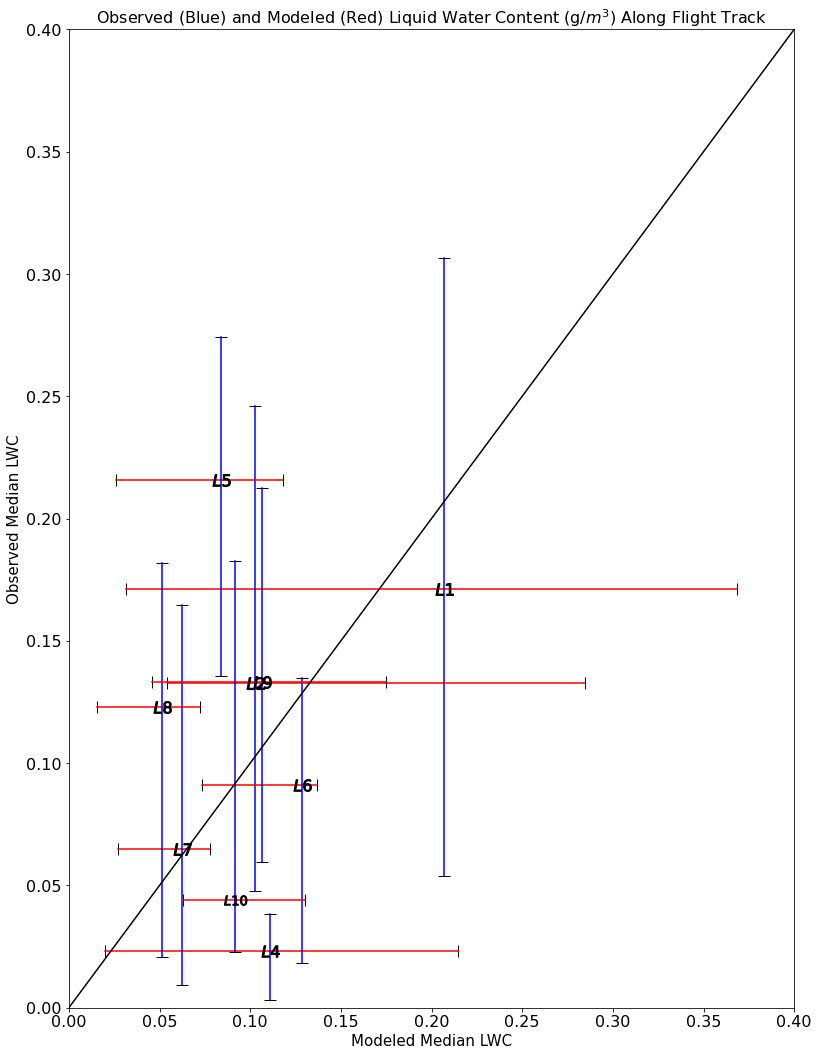

In [103]:
fig, ax = plt.subplots()
plt.plot(l1_m_75,l1_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l1_m_25,l1_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l1_m_median, l1_p_25,'_',markersize = 12, color = 'black') 
plt.plot(l1_m_median,l1_p_75,'_',markersize = 12, color = 'black') 
x_values = [l1_m_25,l1_m_75]
y_values = [l1_p_median,l1_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l1_p_25,l1_p_75]
x_values = [l1_m_median,l1_m_median]
plt.plot(x_values, y_values, color = 'blue')

#leg2
plt.plot(l2_m_75,l2_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l2_m_25,l2_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l2_m_median, l2_p_25,'_',markersize = 12, color = 'black') 
plt.plot(l2_m_median,l2_p_75,'_',markersize = 12, color = 'black')  
x_values = [l2_m_25,l2_m_75]
y_values = [l2_p_median,l2_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l2_p_25,l2_p_75]
x_values = [l2_m_median,l2_m_median]
plt.plot(x_values, y_values, color = 'blue')

#leg 3
# plt.plot(l3_m_75,l3_p_median,marker='|', markersize = 12, color = 'black') 
# plt.plot(l3_m_25,l3_p_median,'|', markersize = 12, color = 'black') 
# plt.plot(l3_m_median, l3_p_25,'_',markersize = 12, color = 'black') 
# plt.plot(l3_m_median,l3_p_75,'_',markersize = 12, color = 'black') 
# x_values = [l3_m_25,l3_m_75]
# y_values = [l3_p_median,l3_p_median]
# plt.plot(x_values, y_values, color = 'r')
# y_values = [l3_p_25,l3_p_75]
# x_values = [l3_m_median,l3_m_median]
# plt.plot(x_values, y_values, color = 'blue')
# print(model_lwc_L3list)
# print(plane_lwc_L3list)
#Leg 4
plt.plot(l4_m_75,l4_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l4_m_25,l4_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l4_m_median, l4_p_25,'_',markersize = 12, color = 'black') 
plt.plot(l4_m_median,l4_p_75,'_',markersize = 12, color = 'black') 
x_values = [l4_m_25,l4_m_75]
y_values = [l4_p_median,l4_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l4_p_25,l4_p_75]
x_values = [l4_m_median,l4_m_median]
plt.plot(x_values, y_values, color = 'blue')

#Leg 5
plt.plot(l5_m_75,l5_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l5_m_25,l5_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l5_m_median, l5_p_25,'_',markersize = 12, color = 'black') 
plt.plot(l5_m_median,l5_p_75,'_',markersize = 12, color = 'black') 
x_values = [l5_m_25,l5_m_75]
y_values = [l5_p_median,l5_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l5_p_25,l5_p_75]
x_values = [l5_m_median,l5_m_median]
plt.plot(x_values, y_values, color = 'blue')

#Leg 6
plt.plot(l6_m_75,l6_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l6_m_25,l6_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l6_m_median, l6_p_25,'_',markersize = 12, color = 'black')
plt.plot(l6_m_median,l6_p_75,'_',markersize = 12, color = 'black') 
x_values = [l6_m_25,l6_m_75]
y_values = [l6_p_median,l6_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l6_p_25,l6_p_75]
x_values = [l6_m_median,l6_m_median]
plt.plot(x_values, y_values, color = 'blue')

#Leg 7
plt.plot(l7_m_75,l7_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l7_m_25,l7_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l7_m_median, l7_p_25,'_',markersize = 12, color = 'black')
plt.plot(l7_m_median,l7_p_75,'_',markersize = 12, color = 'black')
x_values = [l7_m_25,l7_m_75]
y_values = [l7_p_median,l7_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l7_p_25,l7_p_75]
x_values = [l7_m_median,l7_m_median]
plt.plot(x_values, y_values, color = 'blue')

#Leg 8
plt.plot(l8_m_75,l8_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l8_m_25,l8_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l8_m_median, l8_p_25,'_',markersize = 12, color = 'black')
plt.plot(l8_m_median,l8_p_75,'_',markersize = 12, color = 'black') 
x_values = [l8_m_25,l8_m_75]
y_values = [l8_p_median,l8_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l8_p_25,l8_p_75]
x_values = [l8_m_median,l8_m_median]
plt.plot(x_values, y_values, color = 'blue')

#Leg 9
plt.plot(l9_m_75,l9_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l9_m_25,l9_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l9_m_median, l9_p_25,'_',markersize = 12, color = 'black')
plt.plot(l9_m_median,l9_p_75,'_',markersize = 12, color = 'black')
x_values = [l9_m_25,l9_m_75]
y_values = [l9_p_median,l9_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l9_p_25,l9_p_75]
x_values = [l9_m_median,l9_m_median]
plt.plot(x_values, y_values, color = 'blue')

#Leg 10
plt.plot(l10_m_75,l10_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l10_m_25,l10_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l10_m_median, l10_p_25,'_',markersize = 12, color = 'black') 
plt.plot(l10_m_median,l10_p_75,'_',markersize = 12, color = 'black') 
x_values = [l10_m_25,l10_m_75]
y_values = [l10_p_median,l10_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l10_p_25,l10_p_75]
x_values = [l10_m_median,l10_m_median]
plt.plot(x_values, y_values, color = 'blue')
plt.plot(l1_m_median,l1_p_median,marker = '$L1$', color = 'Black',markersize = 18)
plt.plot(l2_m_median,l2_p_median,marker = '$L2$', color = 'Black',markersize = 18)
#plt.plot(l3_m_median,l3_p_median,marker = '$L3$', color = 'Black',markersize = 18)
plt.plot(l4_m_median,l4_p_median,marker = '$L4$', color = 'black',markersize = 18)
plt.plot(l5_m_median,l5_p_median,marker = '$L5$', color = 'Black',markersize = 18)
plt.plot(l6_m_median,l6_p_median,marker = '$L6$', color = 'Black',markersize = 18)
plt.plot(l7_m_median,l7_p_median,marker = '$L7$', color = 'Black',markersize = 18)
plt.plot(l8_m_median,l8_p_median,marker = '$L8$', color = 'Black',markersize = 18)
plt.plot(l9_m_median,l9_p_median,marker = '$L9$', color = 'Black',markersize = 18)
plt.plot(l10_m_median,l10_p_median,marker = '$L10$', color = 'Black',markersize = 23)
y_values = [0,.4]
x_values = [0,.4]
plt.plot(x_values, y_values, color = 'black')
plt.title("Observed (Blue) and Modeled (Red) Liquid Water Content (g/$m^3$) Along Flight Track", fontsize = 16)
fig.set_size_inches(13,18)
#ax.set_xticks([0,5,10,15,20,25,30,35])
#ax.set_yticks([0,5,10,15,20,25,30,35])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("Modeled Median LWC", fontsize = 15)
plt.ylabel("Observed Median LWC",fontsize = 15)
plt.ylim(0,.4)
plt.xlim(0,.4)
plt.show()
fig.savefig("LWC_Legs_rip_LWC.png", dpi = 1500)